### Natural Language Processing Project: "First Take"

MSDS NLP

Kishan Panchal

<img src="../presenters.jpg">

This project aims to see if we can distinguish between the tweets of Stephen A. Smith (left) and Skip  Bayless (right), who are two prominent sports debaters. They used to work together on a show called "First Take" on ESPN before leading their own sports debate shows. Since they work in the media, both are known for their strong opinions and exaggerations, and now that they do no directly debate with each other, some of their opinions are very similar, and they both comment on recent sports news. Thus, it is interesting to take their tweets and see if we can distinguish between the two.

### Data Acquisition

To acquire the data, I used the the Twitter teepy API to request the most recent 3,200 tweets for both Stephen A. Smith (@stephenasmith) and Skip Bayless (@RealSkipBayless). The earliest date for a tweet was November 3, 2016 for Stephen A. and September 17, 2017 for Skip and the most recent date is May 31, 2018 for both people. The script is included within another file. After obtaining the data for both people, I combined it together and labeled tweets by Stephen A. and Skip so that we can distnguish between them.

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [89]:
import pandas as pd   
import numpy as np
import re
from nltk.corpus import stopwords 
from collections import Counter
import pyLDAvis.gensim
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from display_cm import *

pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

In [75]:
smith = pd.read_csv('../Data/stephenasmith_tweets.csv')
smith['label'] = 0

skip = pd.read_csv('../Data/RealSkipBayless_tweets.csv')
skip['label'] = 1

In [76]:
smith.head(4)

,id,created_at,text,label
0,1002000207343534080,2018-05-31 01:34:00,After Dark Podcast: Reasons why Colangelo dese...,0
1,1001920206288060417,2018-05-30 20:16:06,RT @FirstTake: The stage is finally set. Join ...,0
2,1001868088353181697,2018-05-30 16:49:00,My Lord!!! We're talking burner accounts. #ESP...,0
3,1001665250985463809,2018-05-30 03:23:00,Stephen A. Smith After Dark Podcast: The @Warr...,0


In [77]:
skip.head(4)

,id,created_at,text,label
0,1001998406540292097,2018-05-31 01:26:51,I've got a funny feeling about this Finals.,1
1,1001908778441236482,2018-05-30 19:30:42,Today's Undisputed podcast: https://t.co/OA90o...,1
2,1001839619162296322,2018-05-30 14:55:53,Are the Lakers getting serious about drafting ...,1
3,1001836769703223296,2018-05-30 14:44:33,"The Warriors are vulnerable. More @Undisputed,...",1


In [78]:
smith_df = smith[['text', 'label']]
skip_df = skip[['text', 'label']]

train = pd.concat( [smith_df, skip_df] ).reset_index()

In [7]:
train['text'][0]

'After Dark Podcast: Reasons why Colangelo deserves the benefit of the doubt. @IsiahThomas joins with a fantastic MJ v. LeBron argument. https://t.co/1sy8aKjl30'

### Data Processing

Now we need to clean the tweet data. We can do this by removing non-letter characters, getting rid of any links mentioned in the tweets, converting words to lower case, removing stop words, and removing words from other_stops, which are words that appear in tweets that make it easier to identify the tweet owner. Stemming ends up removing some of the meaning of words in this case and thus was not used.

These include twitter handles of cohosts and mentions of the names of the TV shows and companies that Stephen A. and Skip work for.

In [8]:
other_stops = ['stephen', 'a.', 'smith', 'skip bayless', '@undisputed.',\
               '@undisputed', '9:30','rt','&amp', '&amp;', '@undisputed:', \
               '@firsttake', '@firsttake:', 'et.', 'fs1', 'shannon sharpe',\
               'stephen a.', 'a. smith', 'a', ',', '@stephenasmith', '@ShannonSharpe',\
               '@RealSkipBayless', 'undisputed', '-', 'after', 'dark', 'first', 'take',
               '@maxkellerman', 'espn', 'podcast', 'podcast:', '.@stephenasmith',\
               '@undisputed,', '...', 'vs', '--', 'firsttake', 'stephenasmith',
               'amp', 'fs', 'et', 'maxkellerman', 'ShannonSharpe', 'facebook',
               'max', 'kellerman', 'shannon', 'sharpe']

In [9]:
def process_tweet(tweet):

    no_links = re.sub(r'(www|http:|https:)+[^\s]+[\w]', ' ', str(tweet))
    
    letters_only = re.sub(r'[^a-zA-Z]', ' ', str(no_links)) 
        
    words = letters_only.lower().split()
    
    words = [w for w in words if w not in set(stopwords.words("english"))] 
    
    words = [w for w in words if w not in set(other_stops)]
    
    words = [w for w in words if len(w) > 1]
    
    return " ".join(words)

In [10]:
print('Original Tweet: ' + '%s' %(train['text'][3]))

print('\nCleaned tweet: ' + '%s' %(process_tweet(train['text'][3])))

Original Tweet: Stephen A. Smith After Dark Podcast: The @Warriors win over the #Rockets, and I'm also not impressed with @KingJames despite his success this year. https://t.co/782nywEFOK

Cleaned tweet: warriors win rockets also impressed kingjames despite success year


In [11]:
train['text'] = train['text'].apply(process_tweet)

In [12]:
train.sample(5)

,index,text,label
2759,2759,yes use new radio show comment jim brown rep j...,0
2535,2535,lavar ball inviting microscope son reasons mig...,0
3241,16,sorry lebron bad nba finals many losses mj win...,1
5433,2208,eric dickerson joins us debate whether tom bra...,1
3205,3205,admit nervous hell never done life boys danraf...,0


### Exploratory Data Analysis

#### Most Frequent Words Used

What are the top 25 most common words used by Stephen A. Smith?

In [13]:
smith_tokens = " ".join(train[train['label']==0]['text']).split(" ")
smith_dict = Counter(smith_tokens)

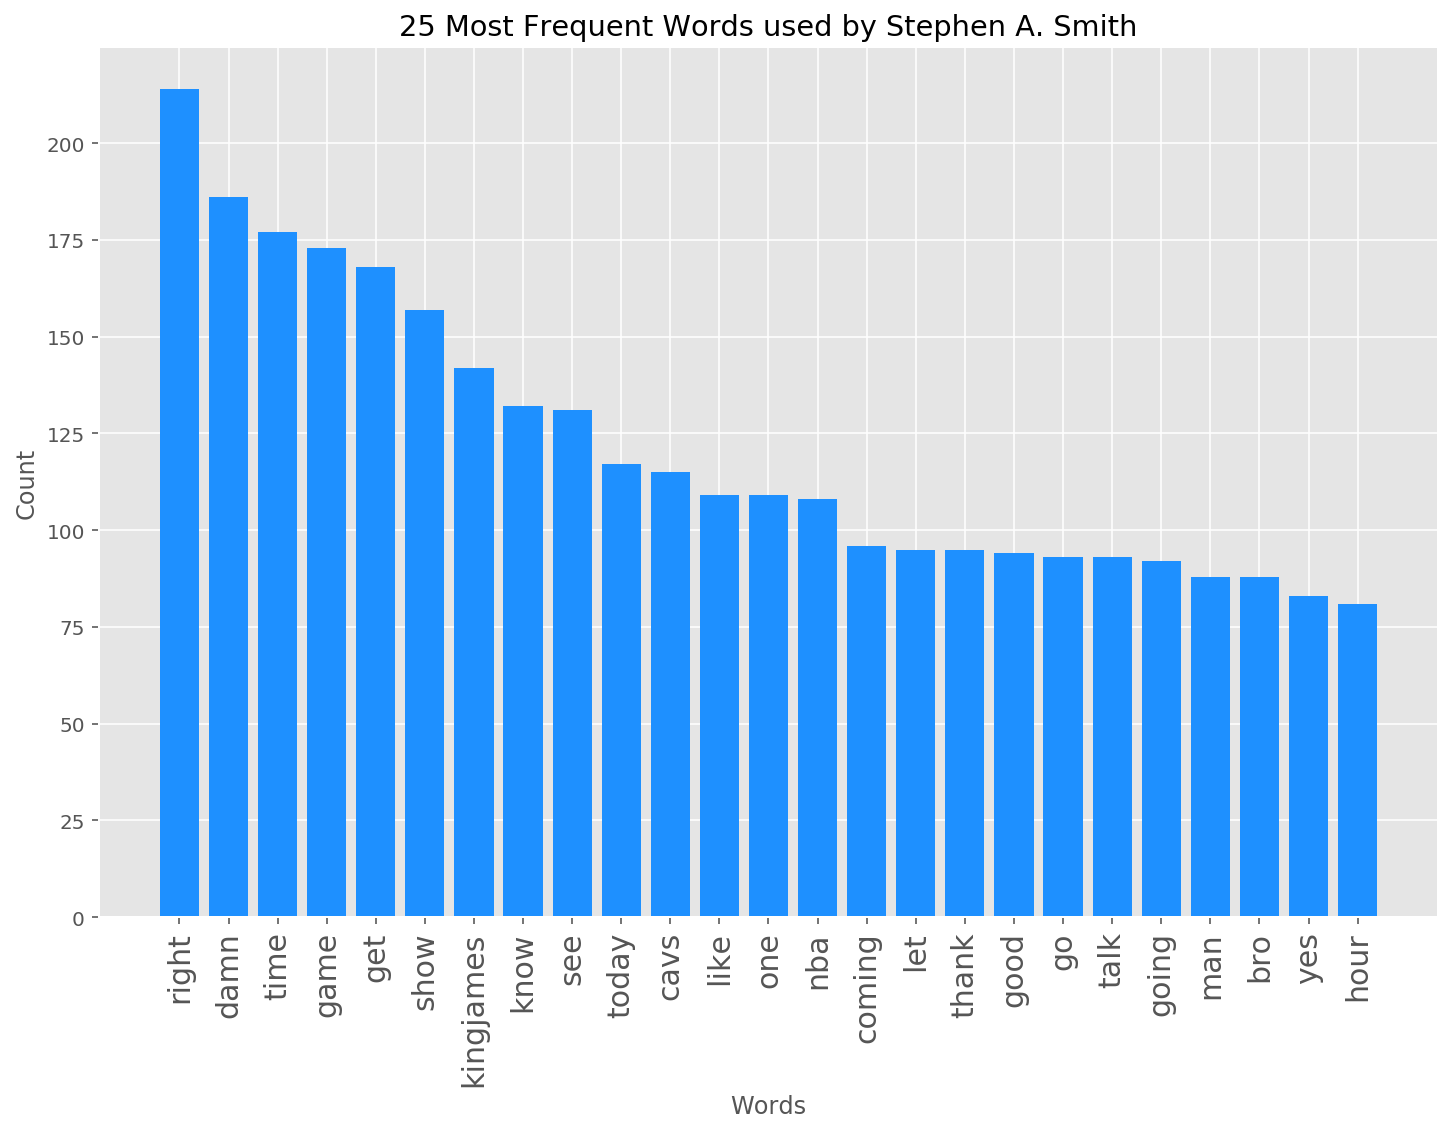

In [102]:
labels, values = zip(*smith_dict.most_common(25))

plt.figure(figsize=(12,8))
plt.bar(labels, values, color = 'dodgerblue')
plt.xticks(labels, rotation = 90, size=15)
plt.xlabel('Words', size=12)
plt.ylabel('Count', size=12)
plt.title('25 Most Frequent Words used by Stephen A. Smith')
plt.show()

What are the 25 most common words used by Skip Bayless?

In [15]:
skip_tokens = " ".join(train[train['label']==1]['text']).split(" ")
skip_dict = Counter(skip_tokens)

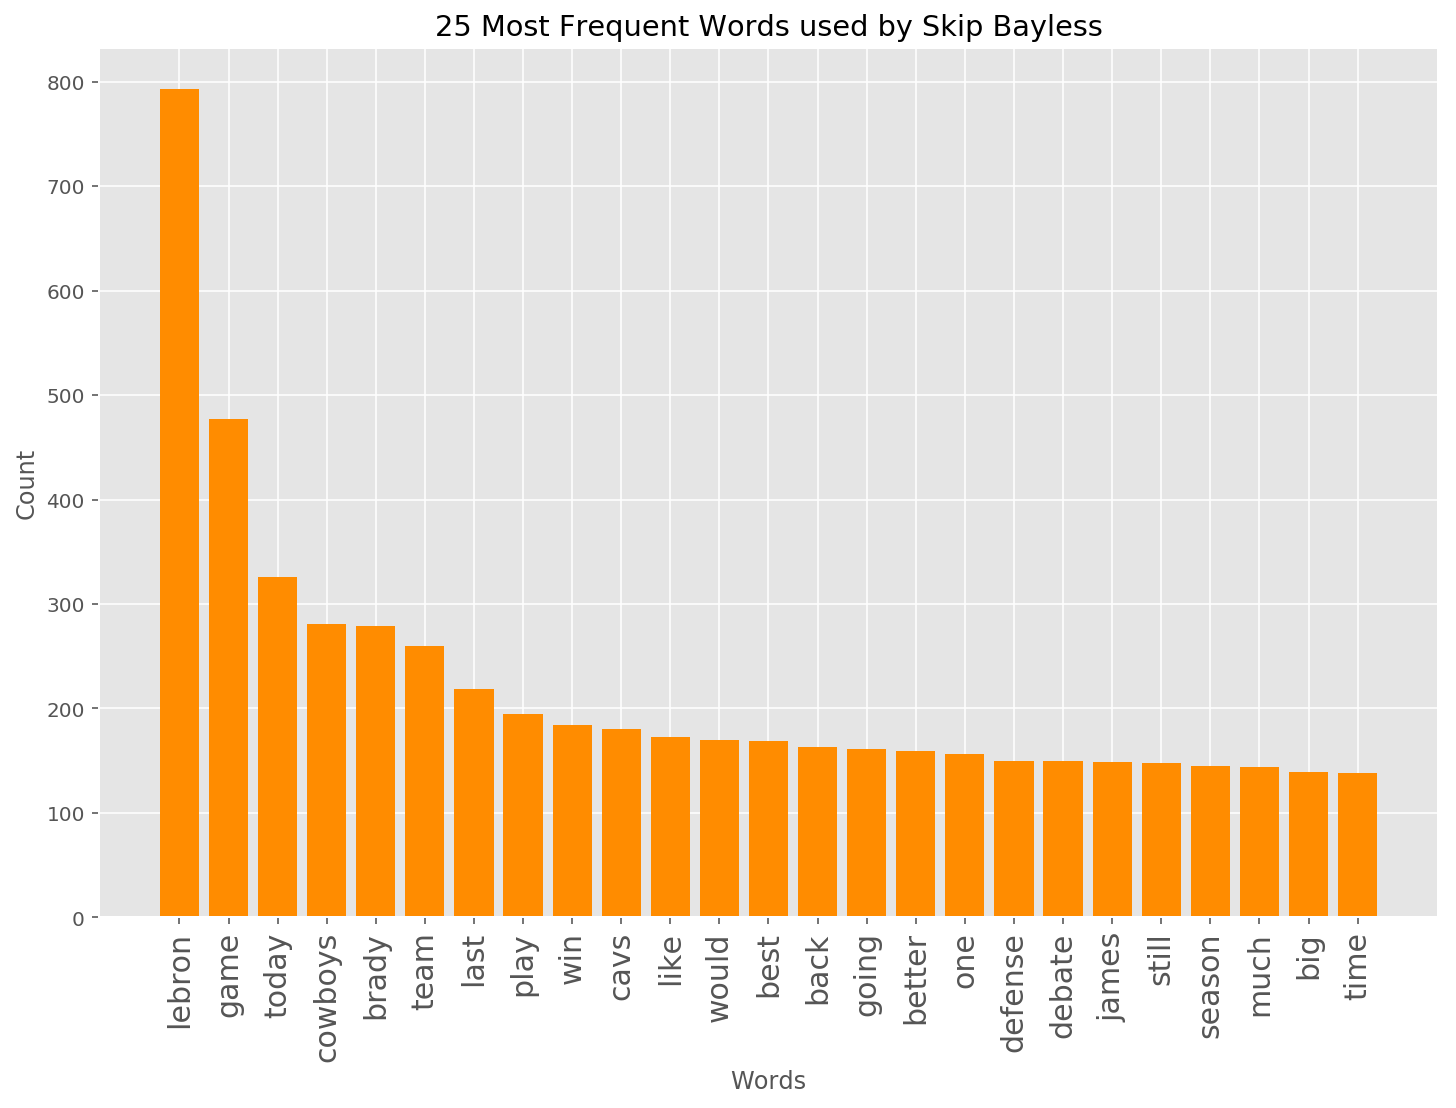

In [103]:
labels, values = zip(*skip_dict.most_common(25))

plt.figure(figsize=(12,8))
plt.bar(labels, values, color = 'darkorange')
plt.xticks(labels, rotation = 90, size=15)
plt.xlabel('Words', size=12)
plt.ylabel('Count', size=12)
plt.title('25 Most Frequent Words used by Skip Bayless')
plt.show()

From the two graphs above, it looks like Skip refers to LeBron James (lebron), the Dallas Cowboys (cowboys), and the Cleveland Cavaliers (cavs) the most in his tweets whereas Stephen A. uses the word 'damn' quite frequently and also mentions LeBron James (kingjames) and the Cleveland Cavaliers (cavs) as well. These plots also depend on the fact that LeBron James routinely breaks NBA records, so it makes sense that he would be mentioned quite often by individuals working in sports debate.

#### Topic Modeling

Topic modeling will help us get a sense of the topics that these sports personalities have talked about from their tweets. Let's check out the five main topics their tweets were about.

Each topic is represented by a circle, and the area of each circle represents the prevalence of a topic, and the numbers in ascending order represent the largest areas. The distance between circles represents topic similarity. Clicking on a circle will give you the most revelant words in a topic. The red bar is the term frequency in this topic, and the blue bar is the overall term frequency. Sliding the lambda slider to 0 results in terms that are mostly only relevant to the topic itself.

In [21]:
all_texts = [ text.split(' ') for text in train['text'] ]
dictionary = corpora.Dictionary(all_texts)

corpus = [dictionary.doc2bow(text) for text in all_texts]
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary)

viz = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
viz

/Users/mbk/anaconda/envs/nlp/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.014822  0.107753       1        1  25.948732
0     -0.018257  0.044208       2        1  19.829870
2      0.116447  0.017266       3        1  19.766344
1      0.044496 -0.145814       4        1  18.049843
4     -0.157508 -0.023413       5        1  16.405210, topic_info=     Category        Freq      Term       Total  loglift  logprob
term                                                             
1381  Default  583.000000   cowboys  583.000000  30.0000  30.0000
419   Default  566.000000     today  566.000000  29.0000  29.0000
3138  Default  283.000000       dak  283.000000  28.0000  28.0000
1824  Default  235.000000    debate  235.000000  27.0000  27.0000
1276  Default  208.000000       dez  208.000000  26.0000  26.0000
6732  Default  109.000000     odell  109.000000  25.0000  25.0000
13    Default  152.000000      join  152.000000  24.0000  24.0000
2109  Default  154.000000     aaron  154.000000  23.0000  23.0000
247   Default   89.000000      russ   89.000000  22.0000  22.0000
434   Default  176.000000       tom  176.000000  21.0000  21.0000
138   Default  220.000000        go  220.000000  20.0000  20.0000
622   Default  164.000000      live  164.000000  19.0000  19.0000
430   Default  360.000000     brady  360.000000  18.0000  18.0000
3025  Default  120.000000       cam  120.000000  17.0000  17.0000
62    Default  126.000000     james  126.000000  16.0000  16.0000
1163  Default   77.000000      melo   77.000000  15.0000  15.0000
3315  Default   65.000000    throws   65.000000  14.0000  14.0000
1484  Default   68.000000    clutch   68.000000  13.0000  13.0000
8     Default  684.000000    lebron  684.000000  12.0000  12.0000
2499  Default   97.000000      easy   97.000000  11.0000  11.0000
2060  Default   94.000000      eric   94.000000  10.0000  10.0000
700   Default   93.000000     jerry   93.000000   9.0000   9.0000
2795  Default   72.000000       nfc   72.000000   8.0000   8.0000
2673  Default   74.000000    dallas   74.000000   7.0000   7.0000
154   Default   56.000000      drop   56.000000   6.0000   6.0000
140   Default  174.000000      good  174.000000   5.0000   5.0000
3139  Default   69.000000  prescott   69.000000   4.0000   4.0000
1668  Default   92.000000      sean   92.000000   3.0000   3.0000
70    Default   76.000000   michael   76.000000   2.0000   2.0000
2113  Default  127.000000   rodgers  127.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
668    Topic5   23.602739        ty   27.404747   1.6582  -6.1099
948    Topic5   21.184416   jackson   24.385096   1.6669  -6.2180
1824   Topic5  151.383698    debate  235.482437   1.3658  -4.2514
1393   Topic5   54.060360   whether   72.614952   1.5125  -5.2812
5789   Topic5   35.593060    carson   47.322830   1.5227  -5.6991
164    Topic5   39.118359     thank   54.503994   1.4759  -5.6047
700    Topic5   60.339661     jerry   93.270370   1.3721  -5.1713
2060   Topic5   58.816433      eric   94.560226   1.3328  -5.1968
2109   Topic5   81.590668     aaron  154.345642   1.1701  -4.8695
701    Topic5   29.685629     jones   43.666805   1.4216  -5.8806
184    Topic5   89.964706       nfl  256.718262   0.7590  -4.7718
329    Topic5   46.037510      line   90.233902   1.1346  -5.4418
374    Topic5   75.847588       big  216.754150   0.7575  -4.9425
2113   Topic5   54.897369   rodgers  127.339043   0.9662  -5.2658
8      Topic5  133.474640    lebron  684.035156   0.1735  -4.3773
356    Topic5   34.765854      gets   60.304771   1.2568  -5.7226
282    Topic5   62.152962       get  200.548004   0.6361  -5.1417
7      Topic5   54.266888     joins  164.589600   0.6980  -5.2773
177    Topic5   40.579258     could   90.234070   1.0084  -5.5680
277    Topic5   58.707676      ball  217.697998   0.4970  -5.1987
143    Topic5   57.524750      much  219.914719   0.4665  -5.2190
18     Topic5  

From the above visualization, we notice that Topic 1 is primarily basketball-related, as it contains many references to LeBron James, Lonzo Ball, Magic Johnson, LaVar Ball, Carmelo Anthony, and the Oklahoma City Thunder.

Topic 2 seems like more of a mix of basketball and football, and Topic 3 seems like a primarily football topic with references to Tom Brady, Dez Bryant, the New England Patriots, DeShaun Jackson, the Dallas Cowboys, Ezekeiel Elliot, Bill Belichick, Baker Mayfield, and Rob Gronkowski. Topic 4 is also mainly football-focused, and Topic 5 is football and baseball-related.

Thus, the two main topics that Stephen A. Smith and Skip Bayless tweeted about were basketball and football.

### Modeling 

In [26]:
X=np.array(train['text'])
y=np.array(train['label'])

In [27]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 20000) 

In [28]:
train_data_features = vectorizer.fit_transform(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_data_features, y, test_size=0.15, random_state=42)

In [30]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5466, 8719) (5466,) (965, 8719) (965,)


### Random Forest

In [31]:
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit( X_train, y_train )

In [33]:
test_preds = forest.predict(X_test)
np.sum((test_preds==y_test))/len(test_preds)

0.8652849740932642

### Multinomial Naive Bayes

In [34]:
clf = MultinomialNB()
clf = clf.fit( X_train, y_train )

In [35]:
train_result2 = clf.predict(X_test)
np.sum((train_result2==y_test))/len(train_result2)

0.8932642487046633

### SGD Classifier

In [36]:
clf_sgd = SGDClassifier(loss='perceptron', penalty='l2', alpha=6e-4, random_state=42)
clf_sgd = clf_sgd.fit( X_train, y_train )

In [37]:
train_result3 = clf_sgd.predict(X_test)

In [38]:
np.sum((train_result3==y_test))/len(train_result3)

0.8756476683937824

In [40]:
confusion_matrix(y_test, train_result2)

array([[424,  83],
       [ 20, 438]])

In [47]:
def display_evaluation_metrics(true_labels, predicted_labels, positive_class=1):
    
    print( 'Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        2))
    print( 'Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               pos_label=positive_class,
                                               average='binary'),
                        2))
    print( 'Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               pos_label=positive_class,
                                               average='binary'),
                        2))
    print( 'F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               pos_label=positive_class,
                                               average='binary'),
                        2))

In [99]:
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print( report)

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


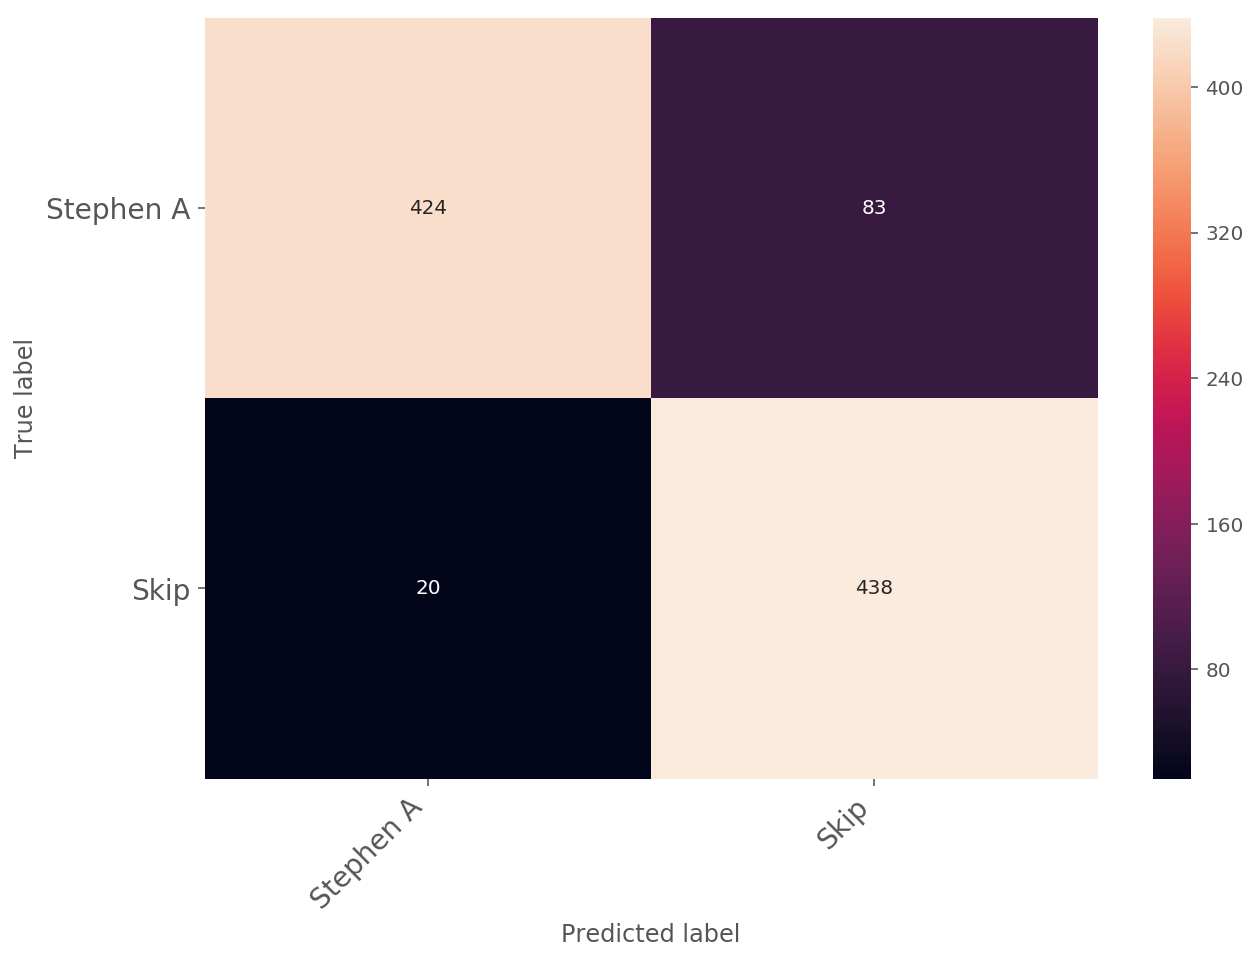

In [97]:
print_confusion_matrix( confusion_matrix(y_test, train_result2), class_names = ['Stephen A', 'Skip'])

In [85]:
display_evaluation_metrics(y_test, train_result2)

Accuracy: 0.89
Precision: 0.84
Recall: 0.96
F1 Score: 0.89


In [100]:
display_classification_report(y_test, train_result2)

             precision    recall  f1-score   support

          1       0.84      0.96      0.89       458
          0       0.95      0.84      0.89       507

avg / total       0.90      0.89      0.89       965



### References 

https://radimrehurek.com/gensim/tut1.html